<a href="https://colab.research.google.com/github/mainulfikri08/Belajar_VAE_Tesis/blob/main/VAE_ver_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import pandas as pd
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
    )
from keras.layers.convolutional import (
    Conv1D,
    MaxPooling1D
    )

# Load data
train = pd.read_csv('/content/drive/MyDrive/Thesis/Dataset/calibrated/train_final_c/train_10_c.csv')
test = pd.read_csv('/content/drive/MyDrive/Thesis/Dataset/calibrated/valid_final_c/valid_10_c.csv')


In [2]:
train.shape

(91000, 13)

In [3]:
x_train = train[["GX", "GY", "Active Button"]]
x_test = test[["GX", "GY", "Active Button"]]

y_train = pd.read_csv('/content/drive/MyDrive/Thesis/Dataset/hasil_labeling_train_c.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Thesis/Dataset/hasil_labeling_valid_c.csv')

In [4]:
x_train.shape

(91000, 3)

In [18]:
n_timestep = 100
num_channels = 1

x_train = (train.values[:,0:2])
feature_baru_train = int(x_train.shape[0]/n_timestep)
x_train = x_train.reshape((feature_baru_train,2, n_timestep, num_channels))

x_test = (test.values[:,0:2])
feature_baru_test = int(x_test.shape[0]/n_timestep)
x_test = x_test.reshape((feature_baru_test,2, n_timestep, num_channels))

input_shape=(n_timestep, feature_baru_train)

In [19]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((910, 2, 100, 1), (910, 1), (416, 2, 100, 1), (416, 1))

In [12]:
n_timestep  = x_train.shape[1]
n_features = x_train.shape[2]
num_channels = 1 #MNIST --> grey scale so 1 channel
x_train = x_train.reshape(x_train.shape[0], n_features, n_timestep, num_channels)
#x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
#input_shape = (n_timestep, n_features) #ganti jadi GX, GY, Active Button

In [13]:
x_train.shape

(910, 2, 100, 1)

In [20]:
# BUILD THE MODEL

# # ================= #############
# # Encoder
#Let us define 4 conv2D, flatten and then dense
# # ================= ############

latent_dim = 2 # Number of latent dim parameters

input_data = Input(shape=input_shape, name='encoder_input')
x = Conv1D(filters=64, kernel_size=3, activation='relu',)(input_data)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu',)(x)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, for latent mean and log variance (std. dev.)
#Use these to sample random variables in latent space to which inputs are mapped. 
z_mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input

#REPARAMETERIZATION TRICK
# Define sampling function to sample from the distribution
# Reparameterize sample based on the process defined by Gunderson and Huang
# into the shape of: mu + sigma squared x eps
#This is to allow gradient descent to allow for gradient estimation accurately. 
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

# sample vector from the latent distribution
# z is the labda custom layer we are adding for gradient descent calculations
  # using mu and variance (sigma)
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_data, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 100, 910)]   0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 98, 64)       174784      ['encoder_input[0][0]']          
                                                                                                  
 conv1d_5 (Conv1D)              (None, 98, 64)       12352       ['conv1d_4[0][0]']               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 98, 64)       12352       ['conv1d_5[0][0]']               
                                                                                            

In [21]:
import tensorflow as tf

# ================= ###########
# Decoder
#
# ================= #################

# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

# Need to start with a shape that can be remapped to original image shape as
#we want our final utput to be same shape original input.
#So, add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2], activation='relu')(decoder_input)
# reshape to the shape of last conv. layer in the encoder, so we can 
x = Reshape((conv_shape[1], conv_shape[2]))(x)
# upscale (conv2D transpose) back to original shape
# use Conv2DTranspose to reverse the conv layers defined in the encoder
x = tf.keras.layers.Conv1DTranspose(32, 3, padding='same', activation='relu')(x)
#Can add more conv2DTranspose layers, if desired. 
#Using sigmoid activation
x = tf.keras.layers.Conv1DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

# apply the decoder to the latent sample 
z_decoded = decoder(z)


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 6272)              18816     
                                                                 
 reshape_1 (Reshape)         (None, 98, 64)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 98, 32)           6176      
 ranspose)                                                       
                                                                 
 decoder_output (Conv1DTrans  (None, 98, 1)            97        
 pose)                                                           
                                                                 
Total params: 25,089
Trainable params: 25,089
Non-trainable

In [23]:
# =========================
#Define custom loss
#VAE is trained using two loss functions reconstruction loss and KL divergence
#Let us add a class to define a custom layer with loss

class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mu = inputs[2]
        z_sigma = inputs[3]
        
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_data, z_decoded, z_mu, z_sigma])
# y is basically the original image after encoding input img to mu, sigma, z
# and decoding sampled z values.
#This will be used as output for vae


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 100, 910)]   0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 98, 64)       174784      ['encoder_input[0][0]']          
                                                                                                  
 conv1d_5 (Conv1D)              (None, 98, 64)       12352       ['conv1d_4[0][0]']               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 98, 64)       12352       ['conv1d_5[0][0]']               
                                                                                                

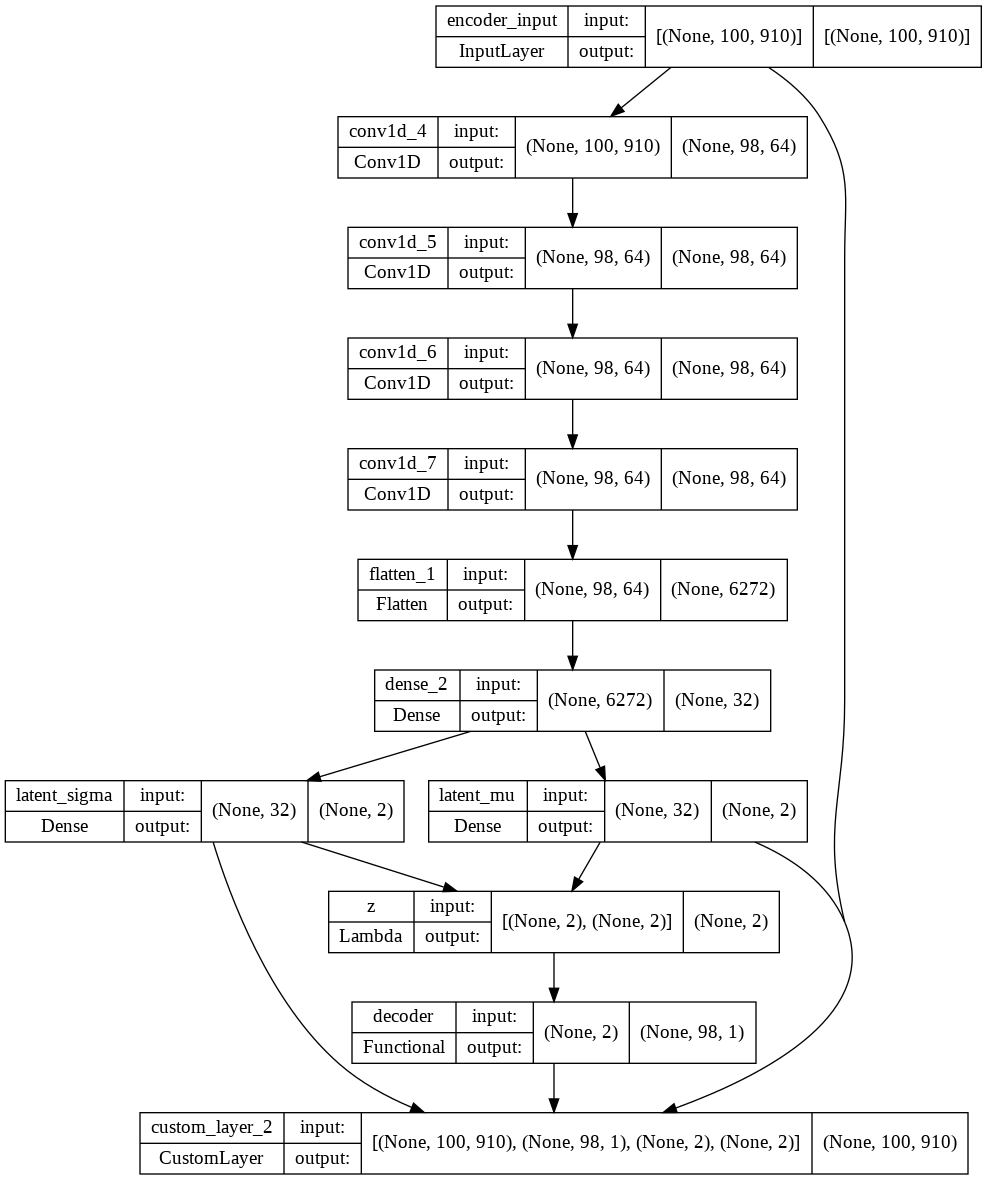

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from IPython.core.display import Image
# =================
# VAE 
# =================
vae = Model(input_data, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

keras.utils.plot_model(vae, "my_first_model_with_shape_info.png", show_shapes=True)

In [25]:
# Train autoencoder
vae.fit(
    x_train, x_train, epochs = 10, batch_size = 32, verbose = 1
    )

Epoch 1/10


ValueError: ignored

In [ ]:
# =================
# Visualize results
# =================
#Visualize inputs mapped to the Latent space
#Remember that we have encoded inputs to latent space dimension = 2. 
#Extract z_mu --> first parameter in the result of encoder prediction representing mean

mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()


# Visualize images
#Single decoded image with random input latent vector (of size 1x2)
#Latent space range is about -5 to 5 so pick random values within this range
#Try starting with -1, 1 and slowly go up to -1.5,1.5 and see how it morphs from 
#one image to the other.
sample_vector = np.array([[1,-1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

#Let us automate this process by generating multiple images and plotting
#Use decoder to generate images by tweaking latent variables from the latent space
#Create a grid of defined size with zeros. 
#Take sample from some defined linear space. In this example range [-4, 4]
#Feed it to the decoder and update zeros in the figure with output.


n = 20  # generate 15x15 digits
figure = np.zeros((img_width * n, img_height * n, num_channels))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()  

IndexError: ignored

<Figure size 720x720 with 0 Axes>